In [1]:
import pickle
from tqdm.notebook import tqdm
import os
import pandas 
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding, Dropout, add

C:\Users\utkar\anaconda4\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
work="C:\crawlers\Project_hastag\save"
base="C:\crawlers\Project_hastag\Archive"

In [3]:
model=VGG16()
model=Model(model.inputs,outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# Feature image
fs={}
directory=os.path.join(base,'Images')

for img in tqdm(os.listdir(directory)):
  img_name=os.path.join(directory,img)
  image=load_img(img_name,target_size=(224,224))
  image=img_to_array(image)
  image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  image=preprocess_input(image)
  f=model.predict(image,verbose=0)
  im_id=img.split(".")[0]
  fs[im_id]=f


  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(fs,open(os.path.join(work,"features.pkl"),"wb"))


In [4]:
with open (os.path.join(work,"features.pkl"),"rb") as f:
  features=pickle.load(f)

In [6]:
with open(os.path.join(base, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
ma={}
data=caption_data.split("\n")
for line in tqdm(data):
  mapp=line.split(",")
  if len(mapp)<2:
    continue
  im_id=mapp[0]
  cap=mapp[1]
  cap="".join(cap)
  im_id=im_id.split(".")[0]
  if im_id not in ma:
    ma[im_id]=[]
  ma[im_id].append(cap)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
def process_text(cap):
  cap=cap.lower()
  cap=cap.replace('[^a-z]',"")
  cap=cap.replace('\s+'," ")
  cap="startseq "+" ".join([word for word in cap.split(" ") if len(word)>1])+" endseq"
  return cap

def clean(ma):
  for key, cap in ma.items():
    for i in range(len(cap)):
      cap[i]=process_text(cap[i])



In [9]:
clean(ma)

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

40455

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [15]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [16]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
epochs = 20
batch_size = 32
steps = len(train)

for i in range(epochs):
    generator = data_generator(train, ma, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 561s 2s/step - loss: 2.1891


In [19]:
model.save(work+'/image_caption.h5')

In [20]:
def idx_word(integer,tok):
    for word,index in tok.word_index.items():
        if index== integer:
            return word
    return none

In [25]:
def predict_caption(model,image,tok,max_len):
    in_text="startseq"
    for i in range(max_len):
        seq=tok.texts_to_sequences([in_text])[0]
        seq=pad_sequences([seq],max_len)
        yhat = model.predict([image, seq], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_word(yhat, tok)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [26]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.535833
BLEU-2: 0.306946


In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq white dog with red ears runs through snow covered field endseq


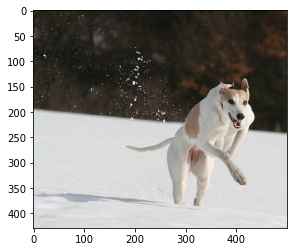

In [30]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is sitting in the middle of tree endseq


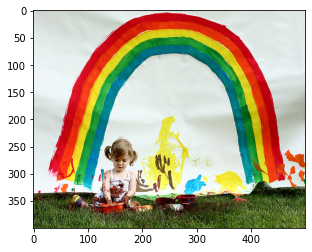

In [29]:
generate_caption("1002674143_1b742ab4b8.jpg")

In [31]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [35]:
image_path = base+'/'+"Image3.png"
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
predict_caption(model, feature, tokenizer, max_length)

'startseq woman in blue shirt and green tank top is holding her hand in the air endseq'